### Maxwell A. Fine 14880725
### Assingment 3: Stastical Methods in Astrophysics

In [17]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
import scipy.integrate as spint
import scipy.interpolate as spinterp
from scipy.integrate import simps
from uncertainties import ufloat

# Set a seed for reproducibility
random_seed = 50

# Gaia correction term
gaia_corr = 0.029 # mas

assigned_clusters = ['NGC_6611', 'NGC_1817', 'NGC_663']



### Initial setup
First, load in the stars data as shown in Assignment 1, and create a dataframe containing only the stars from
the three open clusters which have been assigned to you, which you will use for the remainder of this
assignment. You can include all the stars in your analysis, not just the high-probability cluster members

In [18]:
# Load in Data
# This time I am using _df to indicate it is a pandas df
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
print(dr3stars[1].columns)
stars_df = pd.DataFrame(dr3stars[1].data)
stars_df['Name'] = stars_df['Name'].str.strip()
clcounts = stars_df.groupby(['Name']).size().reset_index(name='count') 


###########################
# grab assigned star clusters
assigned_clusters_df = stars_df[stars_df['Name'].isin(assigned_clusters)]

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   
ColDefs(
    name = 'Name'; format = 'A20'; start = 1
    name = 'ID'; format = 'I4'; disp = 'I4'; start = 22
    name = 'GaiaDR3'; format = 'I19'; disp = 'I19'; start = 27
    name = 'inrt'; format = 'I1'; disp = 'I1'; start = 47
    name = 'Prob'; format = 'F10.8'; disp = 'F10.8'; start = 49
    name = 'RAdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 60
    name = 'e_RAdeg'; format = 'F10.8'; unit = 

### Task 1:
First, make stellar density profiles for each of your three clusters. To do this, you first need to create a
new column in your dataframe which contains the radial separation of each star (in arcseconds) from
the centre of its cluster, i.e. � = 3600. '(� − �̅)! + (� − �/)! where � and � are the RA and DE
positions of the star (in degrees) and �̅and �/ are the means of RA and DE for all the stars in the
cluster (i.e. the estimated location of the centre of the cluster). 

Then, use the radial locations of the
stars to make a histogram of stellar number density �∗ vs. radius, that is, the number of stars in a
radial bin, normalized by the area of the radial bin, which will correspond to an annulus on the sky
(use arcsec2 as the units of area). Choose appropriate radial binning and plot the stellar density
profiles (and error bars, if appropriate) for your 3 clusters on separate plots.

In [22]:
# Lets calculate Mean Ra, Dec for the clusters and add it as a Col in the df
stars_df['mean_RAdeg'] = stars_df.groupby('Name')['RAdeg'].transform('mean')
stars_df['mean_DEdeg'] = stars_df.groupby('Name')['DEdeg'].transform('mean')

# Lets compute radial dinstance (in deg) of each star from the estimated cluster center (the means) and add it as a Col 
# Double check this works as intended 
stars_df['radial_separation'] = np.sqrt((stars_df['RAdeg'] - stars_df['mean_RAdeg'])**2
                                    + (stars_df['DEdeg'] - stars_df['mean_DEdeg'])**2) 




,Name,ID,GaiaDR3,inrt,Prob,RAdeg,e_RAdeg,DEdeg,e_DEdeg,GLON,...,o_GRVSmag,Vbroad,e_Vbroad,o_Vbroad,VarFlag,NSS,RVS,mean_RAdeg,mean_DEdeg,radial_separation
370471,NGC_1817,4491,3394737722648827136,1,1.000000,78.044477,0.025869,16.641971,0.018790,186.187125,...,8.0,12.680986,6.729938,8.0,NOT_AVAILABLE,0,1,78.135085,16.702635,0.109041
370472,NGC_1817,4491,3394753008435729280,1,0.654880,77.773600,0.013236,16.695217,0.010241,185.992678,...,0.0,0.000000,0.000000,0.0,VARIABLE,0,0,78.135085,16.702635,0.361561
370473,NGC_1817,4491,3394710681534170368,0,0.400051,77.468149,0.033844,16.735380,0.020844,185.789703,...,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0,78.135085,16.702635,0.667740
370474,NGC_1817,4491,3394729613750792704,0,0.465658,78.092925,0.148745,16.396855,0.108151,186.422663,...,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0,78.135085,16.702635,0.308672
370475,NGC_1817,4491,3394729854268961536,0,0.405840,78.065005,0.395215,16.415790,0.317574,186.391173,...,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0,78.135085,16.702635,0.295282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786834,NGC_663,4457,511240166386404224,1,0.707762,26.449633,0.075645,61.155310,0.085783,129.442052,...,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0,26.556271,61.190679,0.112351
786835,NGC_663,4457,511240166392490880,1,0.573140,26.461004,0.019802,61.156333,0.023603,129.447203,...,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0,26.556271,61.190679,0.101269
786836,NGC_663,4457,511240166392491008,1,0.608068,26.443304,0.009706,61.155805,0.011845,129.438961,...,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0,26.556271,61.190679,0.118228
786837,NGC_663,4457,511240166392491392,1,0.864659,26.451445,0.010462,61.154153,0.013244,129.443149,...,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0,26.556271,61.190679,0.111008


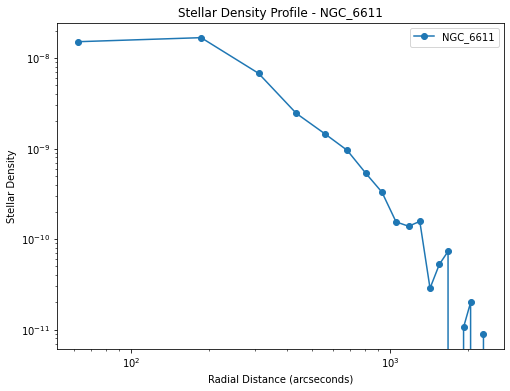

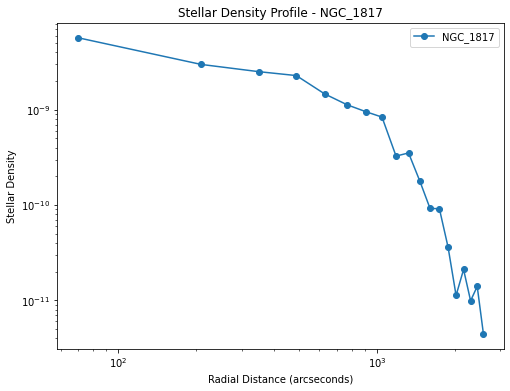

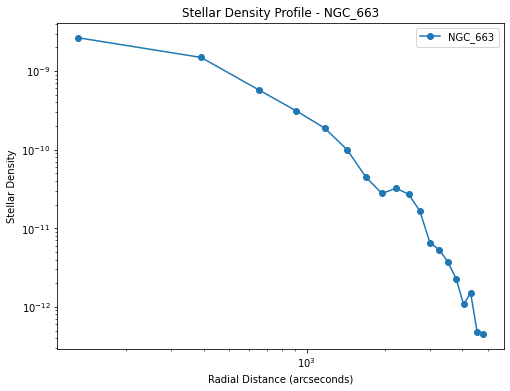

In [14]:


# Step 1: Calculate radial separation for each star
stars['radial_separation'] = np.sqrt((stars['RAdeg'] - stars.groupby('Name')['RAdeg'].transform('mean'))**2
                                    + (stars['DEdeg'] - stars.groupby('Name')['DEdeg'].transform('mean'))**2) * 3600

# Step 2: Calculate mean RA and Dec for each cluster
cluster_centers = stars.groupby('Name')[['RAdeg', 'DEdeg']].mean()

# Step 3: Compute radial distance of each star from the estimated cluster center
stars['radial_distance'] = np.sqrt((stars['RAdeg'] - cluster_centers.loc[stars['Name'], 'RAdeg'].values)**2
                                   + (stars['DEdeg'] - cluster_centers.loc[stars['Name'], 'DEdeg'].values)**2) * 3600

# Step 4: Create a histogram of stellar number density vs. radius
# Step 5: Normalize the histogram by the area of each radial bin
for cluster_name in assigned_clusters:
    cluster_data = stars[stars['Name'] == cluster_name]
    radial_bins = np.linspace(0, cluster_data['radial_distance'].max(), 20)  # Adjust the number of bins as needed
    density, bin_edges = np.histogram(cluster_data['radial_distance'], bins=radial_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    area_of_bin = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    stellar_density = density / area_of_bin

    # Step 6: Plot the stellar density profile for each cluster
    plt.figure(figsize=(8, 6))
    plt.errorbar(bin_centers, stellar_density, yerr=None, fmt='o-', label=cluster_name)
    plt.xlabel('Radial Distance (arcseconds)')
    plt.ylabel('Stellar Density')
    plt.title(f'Stellar Density Profile - {cluster_name}')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
